In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # For plotting theoretical distributions

# Linear Congruential Generator (LCG) Class
class LCG:
    def __init__(self, seed, a=1664525, c=1013904223, m=2**32):
        self.seed = seed
        self.a = a
        self.c = c
        self.m = m
        self.current = seed

    def random(self):
        """
        Generates a pseudo-random number between 0 and 1.
        Every time you call lcg.random(), the current value is updated according to the linear congruential formula: 
        X_{n+1} = (a * X_n + c) mod m
        """
        self.current = (self.a * self.current + self.c) % self.m
        return self.current / self.m  # Normalize to [0, 1)


In [2]:

# Box-Muller Transform for Normal Distribution
def box_muller(lcg):
    u1 = lcg.random()
    u2 = lcg.random()
    z1 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
    z2 = math.sqrt(-2.0 * math.log(u1)) * math.sin(2.0 * math.pi * u2)
    return z1, z2

#### Continuous Distributions
def generate_normal_demand(lcg, mu=0, sigma=1):
    z1, _ = box_muller(lcg)
    return mu + sigma * z1

def generate_uniform_demand(lcg, a=0, b=1):
    u = lcg.random()
    return a + (b - a) * u

def generate_exponential_demand(lcg, lam=1):
    u = lcg.random()
    return -math.log(u) / lam

def generate_lognormal_demand(lcg, mu=0, sigma=1):
    z1, _ = box_muller(lcg)
    return math.exp(mu + sigma * z1)

#===NEW===#
def generate_triangular_demand(lcg, a=0, c=0.5, b=1):
    u = lcg.random()
    if u < (c - a) / (b - a):
        return a + math.sqrt(u * (b - a) * (c - a))
    else:
        return b - math.sqrt((1 - u) * (b - a) * (b - c))
#===NEW===#
def generate_beta_demand(lcg, alpha=2, beta=5):
    """
    Generates a random variable following the Beta distribution using LCG for randomness.
    
    Parameters:
    - lcg: An instance of the LCG class for generating random numbers.
    - alpha: Fixed shape parameter for the first Gamma distribution (default = 2).
    - beta: Fixed shape parameter for the second Gamma distribution (default = 5).
    
    Returns:
    - A beta-distributed random variable in the range [0, 1].
    """
    def generate_gamma(lcg, shape):
        """
        Generates a Gamma-distributed random variable using the acceptance-rejection method.
        """
        if shape < 1:
            # Use Johnk's method for shape < 1
            while True:
                u = lcg.random()
                v = lcg.random()
                x = u ** (1 / shape)
                y = v ** (1 / (1 - shape))
                if x + y <= 1:
                    return -math.log(lcg.random()) * x / (x + y)
        else:
            # Use Marsaglia and Tsang's method for shape >= 1
            d = shape - 1 / 3
            c = 1 / math.sqrt(9 * d)
            while True:
                u = lcg.random()
                v = lcg.random()
                z = (2 * u - 1) * c
                x = d * ((1 + z) ** 3)
                if x > 0 and math.log(v) < 0.5 * z ** 2 + d - d * math.log(x):
                    return x

    # Generate two independent gamma random variables
    x = generate_gamma(lcg, alpha)
    y = generate_gamma(lcg, beta)
    
    # Calculate the beta random variable
    # x = np.random.gamma(alpha, 1)
    # y = np.random.gamma(beta, 1)
    return x / (x + y)

#===NEW===#
def generate_weibull_demand(lcg, lam=1, k=1.5):
    u = lcg.random()
    return lam * (-math.log(1 - u))**(1 / k)

#### Discrete Distributions
def generate_poisson_demand(lcg, lam=1):
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while p > L:
        k += 1
        u = lcg.random()
        p *= u
    return k - 1

def generate_binomial_demand(lcg, n=10, p=0.5):
    successes = 0
    for _ in range(n):
        if lcg.random() < p:
            successes += 1
    return successes

#===NEW===#
def generate_bernoulli_demand(lcg, p=0.5):
    return 1 if lcg.random() < p else 0
#===NEW===#
def generate_geometric_demand(lcg, p=0.5):
    u = lcg.random()
    return math.ceil(math.log(1 - u) / math.log(1 - p))
#===NEW===#
def generate_negative_binomial_demand(lcg, r=10, p=0.5):
    successes = 0
    trials = 0
    while successes < r:
        if lcg.random() < p:
            successes += 1
        trials += 1
    return trials


In [37]:
# Function to simulate demand for any distribution
def simulate_demand(lcg, iterations, distribution='normal', **kwargs):
    demands = []
    for _ in range(iterations):
        if distribution == 'normal':
            demand = generate_normal_demand(lcg, kwargs.get('mu', 0), kwargs.get('sigma', 1))
        elif distribution == 'uniform':
            demand = generate_uniform_demand(lcg, kwargs.get('a', 0), kwargs.get('b', 1))
        elif distribution == 'exponential':
            demand = generate_exponential_demand(lcg, kwargs.get('lam', 1))
        elif distribution == 'poisson':
            demand = generate_poisson_demand(lcg, kwargs.get('lam', 1))
        elif distribution == 'binomial':
            demand = generate_binomial_demand(lcg, kwargs.get('n', 10), kwargs.get('p', 0.5))
        elif distribution == 'lognormal':
            demand = generate_lognormal_demand(lcg, kwargs.get('mu', 0), kwargs.get('sigma', 1))
        elif distribution == 'bernoulli':
            demand = generate_bernoulli_demand(lcg, kwargs.get('p', 0.5))
        elif distribution == 'geometric':
            demand = generate_geometric_demand(lcg, kwargs.get('p', 0.5))
        elif distribution == 'negative_binomial':
            demand = generate_negative_binomial_demand(lcg, kwargs.get('r', 10), kwargs.get('p', 0.5))
        elif distribution == 'triangular':
            demand = generate_triangular_demand(lcg, kwargs.get('a', 0), kwargs.get('c', 0.5), kwargs.get('b', 1))
        elif distribution == 'beta':
            demand = generate_beta_demand(lcg, kwargs.get('alpha', 2), kwargs.get('beta', 5))
        elif distribution == 'weibull':
            demand = generate_weibull_demand(lcg, kwargs.get('lam', 1), kwargs.get('k', 1.5))
        else:
            raise ValueError(f"Unknown distribution: {distribution}")
        demands.append(demand)
    return np.array(demands)

# Plot demand and theoretical distribution
def plot_demand_distribution(demands, distribution, **kwargs):
    plt.hist(demands, bins=50, density=True, alpha=0.6, color='g', label='Simulated Demand')
    
    # Define x-axis range
    x = np.linspace(min(demands), max(demands), 1000)
    
    # Continuous distributions
    if distribution == 'normal':
        mu, sigma = kwargs.get('mu', 0), kwargs.get('sigma', 1)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label='Normal PDF')
    elif distribution == 'uniform':
        a, b = kwargs.get('a', 0), kwargs.get('b', 1)
        plt.plot(x, stats.uniform.pdf(x, a, b - a), 'r-', lw=2, label='Uniform PDF')
    elif distribution == 'exponential':
        lam = kwargs.get('lam', 1)
        plt.plot(x, stats.expon.pdf(x, scale=1/lam), 'r-', lw=2, label='Exponential PDF')
    elif distribution == 'lognormal':
        mu, sigma = kwargs.get('mu', 0), kwargs.get('sigma', 1)
        plt.plot(x, stats.lognorm.pdf(x, sigma, scale=np.exp(mu)), 'r-', lw=2, label='Lognormal PDF')
    elif distribution == 'triangular':
        a, c, b = kwargs.get('a', 0), kwargs.get('c', 0.5), kwargs.get('b', 1)
        plt.plot(x, stats.triang.pdf(x, (c - a) / (b - a), loc=a, scale=b - a), 'r-', lw=2, label='Triangular PDF')
    elif distribution == 'beta':
        alpha, beta = kwargs.get('alpha', 2), kwargs.get('beta', 5)
        plt.plot(x, stats.beta.pdf(x, alpha, beta), 'r-', lw=2, label='Beta PDF')
    elif distribution == 'weibull':
        lam, k = kwargs.get('lam', 1), kwargs.get('k', 1.5)
        plt.plot(x, stats.weibull_min.pdf(x, k, scale=lam), 'r-', lw=2, label='Weibull PDF')

    # Discrete distributions
    elif distribution == 'poisson':
        lam = kwargs.get('lam', 1)
        k = np.arange(0, max(demands) + 1)
        plt.bar(k, stats.poisson.pmf(k, lam), alpha=0.75, label='Poisson PMF', color='b')
    elif distribution == 'geometric':
        p = kwargs.get('p', 0.5)
        k = np.arange(1, max(demands) + 1)
        plt.bar(k, stats.geom.pmf(k, p), alpha=0.75, label='Geometric PMF', color='b')
    elif distribution == 'negative_binomial':
        r, p = kwargs.get('r', 10), kwargs.get('p', 0.5)
        k = np.arange(0, max(demands) + 1)
        plt.bar(k, stats.nbinom.pmf(k, r, p), alpha=0.75, label='Negative Binomial PMF', color='b')
    elif distribution == 'bernoulli':
        p = kwargs.get('p', 0.5)
        k = [0, 1]
        plt.bar(k, stats.bernoulli.pmf(k, p), alpha=0.75, label='Bernoulli PMF', color='b')
    elif distribution == 'binomial':
        n, p = kwargs.get('n', 10), kwargs.get('p', 0.5)
        k = np.arange(0, n + 1)
        plt.bar(k, stats.binom.pmf(k, n, p), alpha=0.75, label='Binomial PMF', color='b')

    # Titles, labels, and legend
    plt.title(f"Demand Distribution: {distribution.capitalize()}")
    plt.xlabel('Demand')
    plt.ylabel('Density' if distribution in ['normal', 'uniform', 'exponential', 'lognormal'] else 'Probability')
    plt.legend()
    plt.grid(True)
    plt.show()


In [45]:
""" old simulate_newsvendor with no holding cost
def simulate_newsvendor(order_quantity, selling_price, unit_cost, salvage_value, demands):
    # Input validation
    if selling_price <= unit_cost:
        raise ValueError("Selling price must be greater than unit cost.")
    if salvage_value > unit_cost:
        raise ValueError("Salvage value cannot exceed the unit cost.")
    if order_quantity < 0:
        raise ValueError("Order quantity cannot be negative.")

    # Calculate profits for all demands
    profits = []
    for demand in demands:
        if demand <= order_quantity:
            profit = selling_price * demand - unit_cost * order_quantity + salvage_value * (order_quantity - demand)
        else:
            profit = selling_price * order_quantity - unit_cost * order_quantity  # Stockout scenario
        profits.append(profit)
    profits = np.array(profits)
    
    # Return the average profit
    return np.mean(profits)
"""
#===NEW===#
""" new simulate_newsvendor with generalized formula to account for salvage value and holding cost"""
def simulate_newsvendor(order_quantity, selling_price, unit_cost, demands, salvage_value, holding_cost):

    # Input validation
    if selling_price <= unit_cost:
        raise ValueError("Selling price must be greater than unit cost.")
    if salvage_value < 0 or holding_cost < 0:
        raise ValueError("Salvage value and holding cost must be non-negative.")
    if order_quantity < 0:
        raise ValueError("Order quantity cannot be negative.")
    
    profits = []
    for demand in demands:
        if demand <= order_quantity:
            # Excess inventory case
            profit = (
                selling_price * demand
                - unit_cost * order_quantity
                + salvage_value * (order_quantity - demand)
                - holding_cost * (order_quantity - demand)
            )
        else:
            # Stockout case
            profit = selling_price * order_quantity - unit_cost * order_quantity
        
        profits.append(profit)
    
    # Return the average profit
    return np.mean(profits)



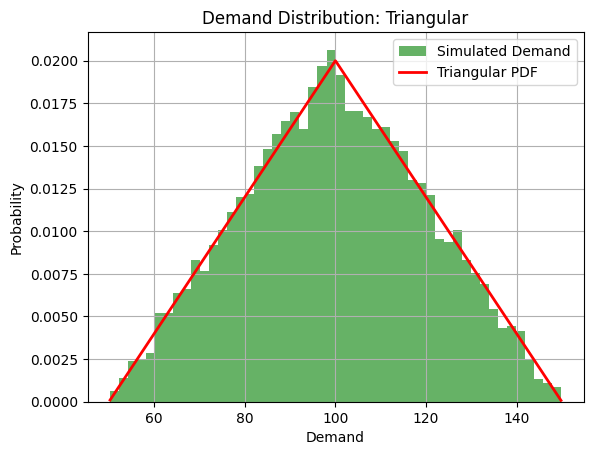

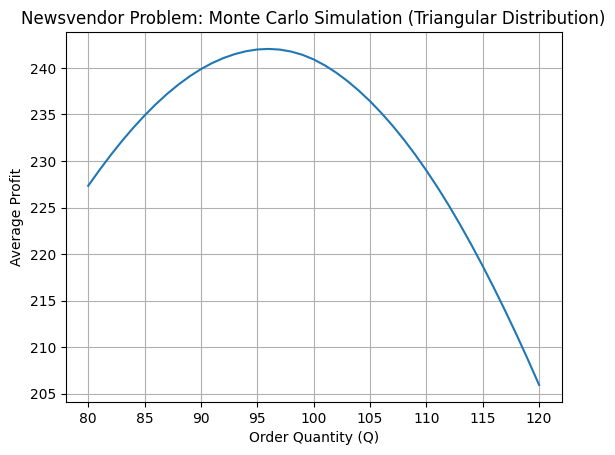

In [48]:
# Parameters for the newsvendor problem
pp = 10  # Selling price per unit
c = 7   # Cost per unit
v = 3   # Salvage value per unit (if unsold)
h = 0   # Holding cost per unit 
order_quantities = np.arange(80, 121)

# Define general parameters for the simulation
iterations = 10000  # Number of iterations for the Monte Carlo simulation
distribution = 'triangular'  # Specify the distribution to use

# in case of some distributions like binomial, we need to adjust order_quantities
if distribution == 'binomial':
    n, p = 100, 0.3
    mu = n * p
    sigma = np.sqrt(n * p * (1 - p))
    order_quantities = np.arange(max(0, int(mu - 3 * sigma)), int(mu + 3 * sigma) + 1)


# Define specific parameters for each distribution
distribution_params = {
    'normal': {'mu': 100, 'sigma': 50},
    'uniform': {'a': 50, 'b': 150},
    'exponential': {'lam': 1/100},
    'poisson': {'lam': 100},
    'lognormal': {'mu': 4.5, 'sigma': 0.75},
    'triangular': {'a': 50, 'c': 100, 'b': 150},
    'beta': {'alpha': 2, 'beta': 5},
    'weibull': {'lam': 1.5, 'k': 1.2},
    'geometric': {'p': 0.3},
    'negative_binomial': {'r': 10, 'p': 0.4},
    'bernoulli': {'p': 0.5},
    'binomial': {'n': 100, 'p': 0.3}
}

# Initialize the LCG with a seed
lcg = LCG(seed=1234)

# Simulate demand based on the specified distribution and parameters
demands = simulate_demand(lcg, iterations, distribution, **distribution_params[distribution])

# Plot the simulated demand along with the theoretical distribution
plot_demand_distribution(demands, distribution, **distribution_params[distribution])

# Calculate the average profit for each order quantity
average_profits = [simulate_newsvendor(Q,pp,c,demands,v,h) for Q in order_quantities]

# Plot the newsvendor simulation results
plt.plot(order_quantities, average_profits)
plt.xlabel('Order Quantity (Q)')
plt.ylabel('Average Profit')
plt.title(f'Newsvendor Problem: Monte Carlo Simulation ({distribution.capitalize()} Distribution)')
plt.grid(True)
plt.show()

In [49]:
optimal_quantity = order_quantities[np.argmax(average_profits)]
optimal_profit = max(average_profits)
print(f"Optimal Order Quantity: {optimal_quantity}")
print(f"Maximum Average Profit: {optimal_profit:.2f}")



Optimal Order Quantity: 96
Maximum Average Profit: 242.04
